# Data Analysis for Master Thesis Project

## Prework

### Environment Preparation

In [58]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import data_prep
import survey_data
import timing_check_function
from pathlib import Path
import pingouin as pg
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np

### Preprocessing

In the preprocessing the datafile wich is created automatically from PsychPy is transformed into a clean format so that analysis can be done. For that reason all available files are read and the prepare data function from the data_prep file is called. The practice trials are sorted out and a new index is created without holding the practice trial.
The questionnaire data is preprocessed in a separate step by calling the survey_data function from the survey_data file.
Both preprocessed data files are stored as csv files.

In [59]:
# List all data files which should be preprocessed
directory = Path('/Users/anja/Desktop/data_mt')
data_files = [file.name for file in directory.glob('*.csv')]

In [60]:
# Preprocess data from experiment
data = data_prep.prepare_data(data_files)

/Users/anja/Documents/GitHub/master_thesis/data_prep.py:153: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concatenated_df = pd.concat(dfs, ignore_index=True)


In [61]:
# Detele practice trials and create practice subset
practice_trials = data[data['block'] == 'Test']
data = data[data['block'] != 'Test']

In [62]:
# Create balance_you and balance_cozmo columns for modelling
# Create the balance update columns
data.loc[(data['owner'] == 'you') & (data['value'] == 'win'), ['update_you', 'update_cozmo']] = [0.4, 0]
data.loc[(data['owner'] == 'you') & (data['value'] == 'lose'), ['update_you', 'update_cozmo']] = [-0.2, 0]
data.loc[(data['owner'] == 'cozmo') & (data['value'] == 'win'), ['update_you', 'update_cozmo']] = [0, 0.4]
data.loc[(data['owner'] == 'cozmo') & (data['value'] == 'lose'), ['update_you', 'update_cozmo']] = [0, -0.2]

# Initialize balance you and balance cozmo columns
data['balance_you'] = 0.0
data['balance_cozmo'] = 0.0

# Group by participant and block, then accumulate update column values within each group
for participant, participant_df in data.groupby('participant'):
    for block, block_df in participant_df.groupby('block'):
        indices = block_df.index
        data.loc[indices, 'balance_you'] = block_df['update_you'].cumsum()
        data.loc[indices, 'balance_cozmo'] = block_df['update_cozmo'].cumsum()

In [63]:
# Create trial index per participant (after test trials were deleted!)
data['trial_index_within_participant'] = data.groupby('participant').cumcount() + 1

In [64]:
# Preprocess data from pavlovia surveys (questionnaire answers)
survey_data = survey_data.survey_data(data_files)

/Users/anja/Documents/GitHub/master_thesis/survey_data.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concatenated_df = pd.concat(dfs, ignore_index=True)


In [65]:
# Store preprocessed data in csv
data.to_csv('/Users/anja/Desktop/data_mt/data_preprocessed.csv', index=False)
survey_data.to_csv('/Users/anja/Desktop/data_mt/data_survey_preprocessed.csv', index=False)

In [66]:
# Number of trails initially available
data.shape[0]

57218

In [67]:
# trial type distribution
data_787053 = data[data['participant']==787053]
condition_dist = data_787053.groupby(['identifier_chooser_owner_value_corr']).agg(count=('identifier_chooser_owner_value_corr', 'count')).reset_index()
print(condition_dist)

  identifier_chooser_owner_value_corr  count
0                    cozmo_cozmo_lose     50
1                     cozmo_cozmo_win     46
2                      cozmo_you_lose     46
3                       cozmo_you_win     50
4                      you_cozmo_lose     51
5                       you_cozmo_win     45
6                        you_you_lose     47
7                         you_you_win     49


### Demographic Data Before Cleaned Data

In this section the demographic data from the survey dataset is analysed to find out how handedness, gender and age are distributed among participants.

In [68]:
# Summarize handedness
survey_data.groupby(['handedness']).agg(count=('handedness', 'count')).reset_index()

,handedness,count
0,left,12
1,other,1
2,right,137


In [69]:
# Summarize age
survey_data['age'].describe()

count    150.000000
mean      28.546667
std        6.012947
min       18.000000
25%       24.000000
50%       28.000000
75%       32.000000
max       45.000000
Name: age, dtype: float64

In [70]:
# Summarize gender
survey_data.groupby(['gender']).agg(count=('gender', 'count')).reset_index()


,gender,count
0,female,61
1,male,88
2,other,1


### Unrealistic response times

It seems like some participants cheated, therefore we need to sort out their data

compare relavant_participants with relevant_participants_filtered to see how many were sorted out (adjust the number of stds to filter out more or less)

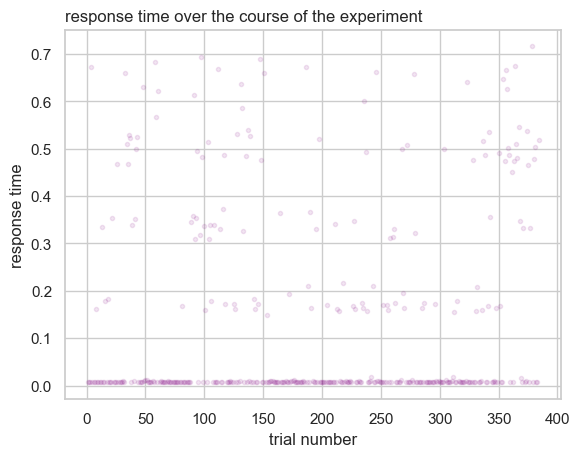

In [71]:
# Plot with transparency
data_787053 = data[data['participant']==787053]
plt.plot( data_787053["trial_index_within_participant"], data_787053["owner_confirm_rt"], data=data_787053, linestyle='', marker='o', markersize=3, alpha=0.1, color="purple")
 
# Titles
plt.xlabel('trial number')
plt.ylabel('response time')
plt.title('response time over the course of the experiment', loc='left')
plt.show()

In [72]:
# Filter out data with unrealistic response times (less or more than 1 std from average response time)
relevant_participants = data.groupby(['participant']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

# Calculate mean and std
mean_response_time = data['owner_confirm_rt'].mean()
std_response_time = data['owner_confirm_rt'].std()

# Calculate bounds
lower_bound = mean_response_time - 1 * std_response_time
upper_bound = mean_response_time + 1 * std_response_time

# Filter relevant participants
relevant_participants_filtered = relevant_participants[
    (relevant_participants['average_response_time'] >= lower_bound) &
    (relevant_participants['average_response_time'] <= upper_bound)
]

# Left join of data with relevant_participants_filtered to sort out participants who cheated
data = data.merge(relevant_participants_filtered[['participant']], on='participant', how='inner')

### Error rates
Since participants have trials where they have been asked to respond faster or reiterate their response because they did not confirm correctly, we'll need to decide which of those trials to keep for analysis and which to sort out. In order to do so, error rates of participants are analysed.

In [73]:
# Error rates per participant
# Add bool column for error in decision
data['error_in_decision'] = data[['bool_slow_color_choice_or_confirm', 'bool_wrong_color_confirm']].any(axis=1).astype(int)

# Add bool column for error in owner confirm
data['error_in_outcome_attribution'] = data[['bool_slow_owner_confirm', 'bool_wrong_owner_confirm']].any(axis=1).astype(int)

# Group by participant and sum the errors
errors_per_participant = data.groupby('participant')[['error_in_decision', 'error_in_outcome_attribution']].sum().reset_index()

# Calculate ratios
total_trials = 384
errors_per_participant['error_in_decision_ratio'] = round(((errors_per_participant['error_in_decision'] / total_trials) * 100),2)
errors_per_participant['error_in_outcome_attribution_ratio'] = round(((errors_per_participant['error_in_outcome_attribution'] / total_trials) *100),2)

errors_per_participant.describe()

,participant,error_in_decision,error_in_outcome_attribution,error_in_decision_ratio,error_in_outcome_attribution_ratio
count,145.000000,145.000000,145.00000,145.000000,145.000000
mean,441723.620690,13.220690,39.37931,3.441724,10.255379
std,312536.295124,11.147664,28.67395,2.903845,7.467470
min,3157.000000,0.000000,3.00000,0.000000,0.780000
25%,177838.000000,6.000000,18.00000,1.560000,4.690000
50%,417785.000000,9.000000,34.00000,2.340000,8.850000
75%,704091.000000,17.000000,47.00000,4.430000,12.240000
max,999482.000000,58.000000,148.00000,15.100000,38.540000


In [74]:
# Filter out participants which did too many error in outcome attribution (more or less than 2,5 stds)
# Calculate mean and std
mean_error = errors_per_participant['error_in_outcome_attribution'].mean()
std_error = errors_per_participant['error_in_outcome_attribution'].std()

# Calculate bounds
lower_bound = mean_error - 2.5 * std_error
upper_bound = mean_error + 2.5 * std_error

# Filter relevant participants
errors_per_participant_filtered = errors_per_participant[
    (errors_per_participant['error_in_outcome_attribution'] >= lower_bound) &
    (errors_per_participant['error_in_outcome_attribution'] <= upper_bound)]

# Left join of data with relevant_participants_filtered to sort out participants who cheated
data = data.merge(errors_per_participant_filtered[['participant']], on='participant', how='inner')

In [75]:
# Total number of trails from filtered participants
total_trials_filtered = data.shape[0]
print(total_trials_filtered)

54144


In [76]:
# Clean remaining participants from rows where outcome attribution response was too slow or wrong 
data = data[(data['bool_slow_owner_confirm'] == False) & 
            (data['bool_wrong_owner_confirm'] == False)]

# Store cleaned data in csv
data.to_csv('/Users/anja/Desktop/data_mt/data_cleaned.csv', index=False)

In [77]:
# Use timing check function to filter out trails where something went wrong with the time settings
trials_with_wrong_timing =  timing_check_function.check_timing()

trials_with_wrong_timing['identifier'] = trials_with_wrong_timing['participant'].astype(str) + '_' + trials_with_wrong_timing['ident_block_trial'].astype(str)
data['identifier'] = data['participant'].astype(str) + '_' + data['block'].astype(int).astype(str) + '_' + data['trial'].astype(int).astype(str)

data = data[~data['identifier'].isin(trials_with_wrong_timing['identifier'])]

/Users/anja/Documents/GitHub/master_thesis/timing_check_function.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concatenated_df = pd.concat(dfs, ignore_index=True)


In [78]:
# Ratio of trails from filtered participants ending up in the analysis
round(data.shape[0] / total_trials_filtered,2)

0.9

In [79]:
# Number of participants ending up in the analysis
len(data['participant'].unique())

141

### Demographics After Cleaned Data

In [80]:
# Check demographic stats for final set of participants, by matching ids
cleaned_participant_ids = data['participant'].unique()
cleaned_survey_data = survey_data[survey_data['participant'].isin(cleaned_participant_ids)]
cleaned_survey_data.to_csv('/Users/anja/Desktop/data_mt/survey_data_cleaned.csv', index=False)

In [81]:
# Age of clean data
cleaned_survey_data['age'].describe()

count    141.000000
mean      28.418440
std        6.008513
min       18.000000
25%       24.000000
50%       27.000000
75%       32.000000
max       45.000000
Name: age, dtype: float64

In [82]:
# Handedness of cleaned data
cleaned_survey_data.groupby(['handedness']).agg(count=('handedness', 'count')).reset_index()

,handedness,count
0,left,12
1,other,1
2,right,128


In [83]:
# Gender of cleaned data
cleaned_survey_data.groupby(['gender']).agg(count=('gender', 'count')).reset_index()

,gender,count
0,female,57
1,male,83
2,other,1


## Analysis

### Normal Distribution

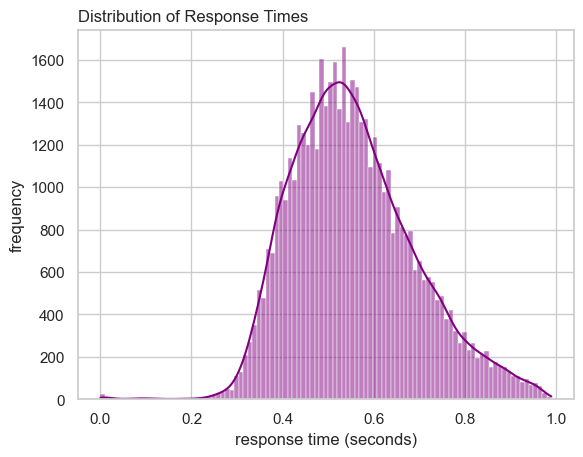

In [84]:
# Histogram of all response times
sns.set_theme(style="whitegrid")

sns.histplot(data=data, x="owner_confirm_rt", color="purple", kde=True)

plt.title('Distribution of Response Times', loc='left')
plt.xlabel('response time (seconds)')
plt.ylabel('frequency')

plt.show()

### Confirm previous results from Abubshait et. al

Are participants faster when confirming give or when confirming keep?

1) In original study participants were faster when outcome was kept by themselves, slower when outcome was given to Cozmo (no matter what outcome value)

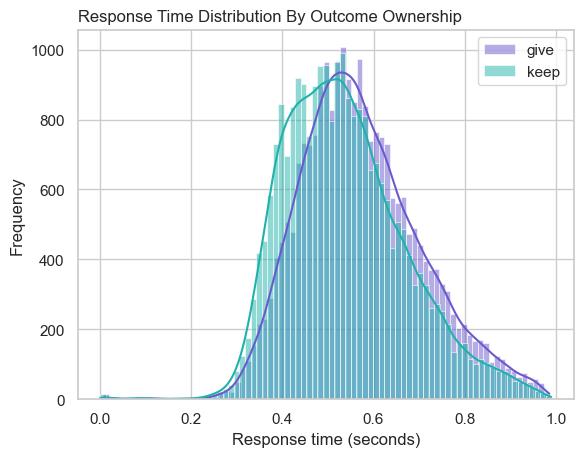

In [85]:
# Histogram of response times
# TODO: mirror https://python-graph-gallery.com/density-mirror/
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")

sns.histplot(data=data[data['owner_confirm_keys'] == 'g'], color = 'slateblue', x="owner_confirm_rt", label="give", kde=True)
sns.histplot(data=data[data['owner_confirm_keys'] == 'k'], color = 'lightseagreen', x="owner_confirm_rt", label="keep", kde=True)

plt.title('Response Time Distribution By Outcome Ownership', loc='left')
plt.xlabel('Response time (seconds)')
plt.ylabel('Frequency')

plt.legend() 
plt.show()

2. In original study when the outcome was kept by oneself it was easier to keep wins and harder to keep losses. This was only found for the participant as outcome owner, not for the robot as outcome owner. This could mean that participants are less invested / interested in the outcomes of Cozmo. There is a differentiation between Cozmo and oneself.

In [86]:
# Group by owner, value
data.groupby(['owner', 'value']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,owner,value,average_response_time,median_response_time
0,cozmo,lose,0.569432,0.5550
1,cozmo,win,0.578373,0.5627
2,you,lose,0.554943,0.5384
3,you,win,0.522503,0.5032


3. In original study participants were faster when the outcome value was winning, no matter which outcome owner it was.

--> Since we already know that giving is harder (takes longer) than keeping, this is probalby anyways driven by the outcome owner = "you" condition

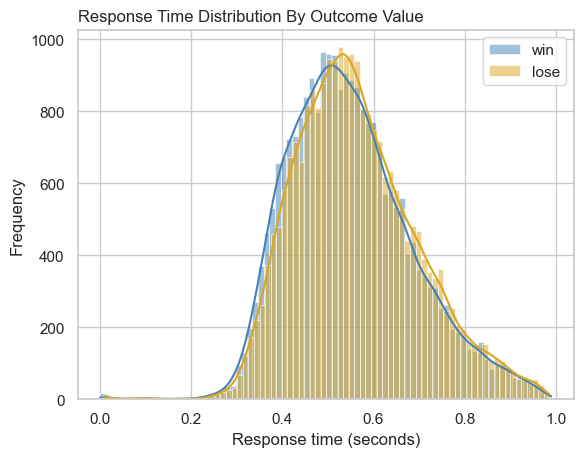

In [87]:
# Histogram of response times
sns.set_theme(style="whitegrid")

sns.histplot(data=data[data['value'] == 'win'], x="owner_confirm_rt", color="steelblue", label="win", kde=True)
sns.histplot(data=data[data['value'] == 'lose'], x="owner_confirm_rt", color="goldenrod", label="lose", kde=True)

plt.title('Response Time Distribution By Outcome Value', loc='left')
plt.xlabel('Response time (seconds)')
plt.ylabel('Frequency')

plt.legend() 
plt.show()

4. Elevated response conflict when giving a win (as compared to give a loss) to Cozmo

One can see this in the differences between giving and keeping for “Win” outcomes (difference is larger) compared to the difference between keeping and giving “Lose” outcomes (smaller difference in reponse times). 

"Since we know that giving in general is harder than keeping, the especially hard condition is to give a win"

In [88]:
data.groupby(['value', 'owner']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,value,owner,average_response_time,median_response_time
0,lose,cozmo,0.569432,0.5550
1,lose,you,0.554943,0.5384
2,win,cozmo,0.578373,0.5627
3,win,you,0.522503,0.5032


#### Re-Examine ANOVA

original paper: "To measure cognitive conflict, participants' reaction times (RTs) to confirm the Keep-Give assignment were analyzed. RTs were averaged for correct trials that were within +/3SD of the overall mean. Averaged RTs were subjected to a 2x2 repeated measures ANOVA with Assignment (Keep vs. Give) and Outcome (Win vs. Lose) as within-factors. Analyses were conducted using R."

--> what was averaged? for each participant or for condition set?

--> df1 ist für alle varialben 1, df2 ist 150 - 8 conditions = 142 --> F(1,142) ; correct for number of participants in the end

--> Interpretation: Small effect: η²_g ≈ 0.01, Medium effect: η²_g ≈ 0.06, Large effect: η²_g ≈ 0.14

In [89]:
# Test for sphericity; Mauchly's; p should be greater 0.05
# https://datatab.net/tutorial/anova-with-repeated-measures

pg.sphericity(data=data, dv='owner_confirm_rt', subject= 'participant', within='identifier_chooser_owner_value_corr')

SpherResults(spher=True, W=70922047462554.39, chi2=-4383.714143822319, dof=27, pval=1.0)

In [90]:
# Test for Homogenity; Levene's; p should be greater 0.05
#https://datatab.net/tutorial/levene-test
pg.homoscedasticity(data=data, dv='owner_confirm_rt', group='identifier_chooser_owner_value_corr')

,W,pval,equal_var
levene,10.88797,8.333810e-14,False


--> homogenity is not so relevant for my study design since I am rather interested in the differences inside one participant, i would like to understand how response time changes within one participant. Not so much over all participants (e.g., response time is a personal measure and therefore it makes sense that there are differences between participants the important thing is within one participant)

In [91]:
# Pingouin ANOVA
anova = pg.rm_anova(dv='owner_confirm_rt', within=['value', 'owner'], data=data, subject='participant', detailed=True)

print(anova)

          Source        SS  ddof1  ddof2        MS           F         p-unc  \
0          value  0.019556      1    140  0.019556   61.241502  1.117986e-12   
1          owner  0.176612      1    140  0.176612  207.651542  1.935699e-29   
2  value * owner  0.058832      1    140  0.058832   80.957130  1.473632e-15   

      p-GG-corr       ng2  eps  
0  1.117986e-12  0.008021  1.0  
1  1.935699e-29  0.068056  1.0  
2  1.473632e-15  0.023748  1.0  


/Users/anja/Documents/GitHub/master_thesis/env/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/anja/Documents/GitHub/master_thesis/env/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


--> Interpretation: Small effect: η²_g ≈ 0.01, Medium effect: η²_g ≈ 0.06, Large effect: η²_g ≈ 0.14

### Results considering Decision Agency (Chooser)

Since the original study found that any outcome given to Cozmo leads to heightened conflict, we assume that decision agency could have a positive shaping effect here. Meaning that when the robot has the agency in decision it makes it again easier to give any outcome because participants are overall less invested.

cozmo_cozmo would have smaller response times there (similar as you_you)

Text(0, 0.5, 'Response time (seconds)')

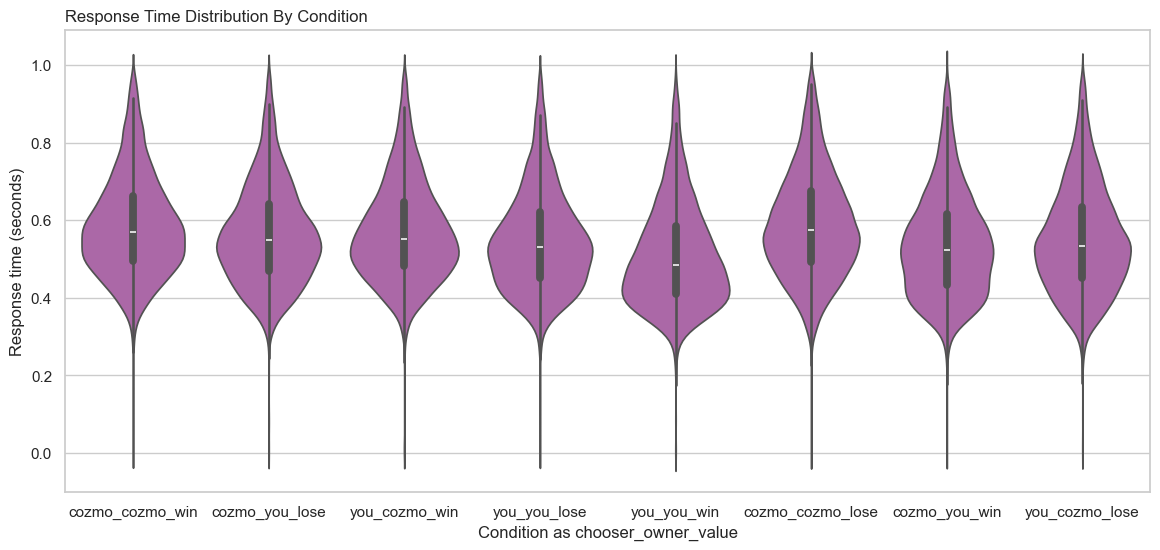

In [92]:
# Reaction time per condition group 
plt.figure(figsize=(14, 6)) 
sns.violinplot( x=data["identifier_chooser_owner_value_corr"], y=data["owner_confirm_rt"], color = '#b65db1' )

plt.title('Response Time Distribution By Condition', loc='left')
plt.xlabel('Condition as chooser_owner_value')
plt.ylabel('Response time (seconds)')


In [93]:
# Group by chooser, owner
data.groupby(['chooser','owner']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,chooser,owner,average_response_time,median_response_time
0,cozmo,cozmo,0.587415,0.5720
1,cozmo,you,0.549269,0.5355
2,you,cozmo,0.560104,0.5440
3,you,you,0.526876,0.5088


In [94]:
# Group by owner, chooser, value
data.groupby(['chooser','owner', 'value']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,chooser,owner,value,average_response_time,median_response_time
0,cozmo,cozmo,lose,0.588558,0.57400
1,cozmo,cozmo,win,0.586183,0.57080
2,cozmo,you,lose,0.563391,0.54805
3,cozmo,you,win,0.536636,0.52360
4,you,cozmo,lose,0.550970,0.53485
5,you,cozmo,win,0.570452,0.55160
6,you,you,lose,0.546795,0.53120
7,you,you,win,0.508276,0.48400


In [95]:
# Statsmodels ANOVA for three factors
aovrm = sm.stats.AnovaRM(data=data, subject= 'participant', depvar='owner_confirm_rt', within=['owner','chooser','value'], aggregate_func='mean')
res = aovrm.fit()
print(res)

                       Anova
                    F Value  Num DF  Den DF  Pr > F
---------------------------------------------------
owner               210.7661 1.0000 140.0000 0.0000
chooser             159.5332 1.0000 140.0000 0.0000
value                65.4829 1.0000 140.0000 0.0000
owner:chooser         2.0590 1.0000 140.0000 0.1535
owner:value          80.7459 1.0000 140.0000 0.0000
chooser:value         5.9286 1.0000 140.0000 0.0162
owner:chooser:value  54.3340 1.0000 140.0000 0.0000



In [96]:
# Mixed linear model
model = smf.mixedlm("owner_confirm_rt ~ chooser * owner * value", data, groups = data["participant"])
result = model.fit()

print(result.summary())

                       Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        owner_confirm_rt
No. Observations:         48906          Method:                    REML            
No. Groups:               141            Scale:                     0.0137          
Min. group size:          275            Log-Likelihood:            35068.4943      
Max. group size:          381            Converged:                 Yes             
Mean group size:          346.9                                                     
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 0.590    0.005 109.005 0.000  0.580  0.601
chooser[T.you]                           -0.037    0.002 -17.970 0.000 -0.041 -0.033
owne

/Users/anja/Documents/GitHub/master_thesis/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Response time over duration of experiment

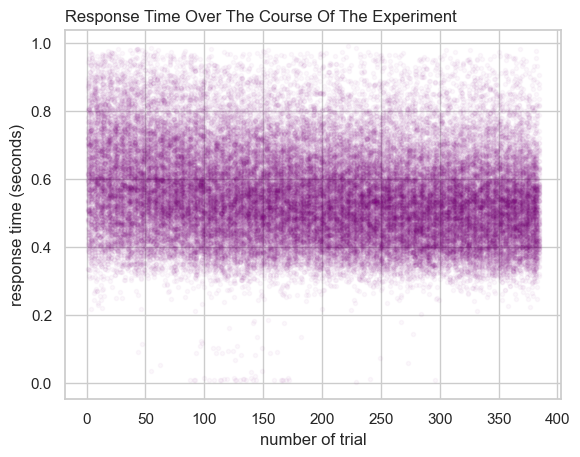

In [97]:
# how does reaction time develope over time? learning effects? do get people faster? 

sns.set_theme(style="whitegrid")

# Plot with transparency
plt.plot( data["trial_index_within_participant"], data["owner_confirm_rt"], data=data, linestyle='', marker='o', markersize=3, alpha=0.03, color="purple")
 
# Titles
plt.xlabel('number of trial')
plt.ylabel('response time (seconds)')
plt.title('Response Time Over The Course Of The Experiment', loc='left')
plt.show()

### Handedness and Choice Location

In [98]:
# Do people prefer one choice when deciding for color? E.g., do right handed people rather choose with 'k' than 'g' when selecting one color
choice_loaction_by_handedness = data[data['chooser'] == 'you']

# Get denominator per participant
denominator = choice_loaction_by_handedness.groupby(['participant']).agg(denominator=('participant', 'count')).reset_index()

# Count of choices per location
choice_loaction_by_handedness = choice_loaction_by_handedness.groupby(['participant', 'choice_location']).agg(choice_location_count=('choice_location', 'count')).reset_index()

# Merge handedenss of participants
choice_loaction_by_handedness = choice_loaction_by_handedness.merge(survey_data[['participant', 'handedness']], on='participant', how='left')

# Merge denominator
choice_loaction_by_handedness = choice_loaction_by_handedness.merge(denominator[['participant','denominator']], on='participant', how='left')

# Create ration column
choice_loaction_by_handedness['ratio'] = choice_loaction_by_handedness['choice_location_count'] / choice_loaction_by_handedness['denominator']

choice_loaction_by_handedness.head()

choice_loaction_by_handedness.groupby(['handedness', 'choice_location']).agg(avg_ratio=('ratio', 'mean'),participant_count =('participant','count')).reset_index()


,handedness,choice_location,avg_ratio,participant_count
0,left,left,0.515933,12
1,left,right,0.484067,12
2,other,left,0.053763,1
3,other,right,0.946237,1
4,right,left,0.482279,128
5,right,right,0.517721,128


In [99]:
# Test for significance - Chi squared

# start to create contingency table
contingency_table = data[data['chooser'] == 'you']
# Merge handedenss of participants
contingency_table = contingency_table.merge(survey_data[['participant', 'handedness']], on='participant', how='left')
# Sort out other handedness
contingency_table = contingency_table[contingency_table['handedness'] != 'other']

# Create contingency table
contingency_table = pd.crosstab(contingency_table['handedness'], contingency_table['choice_location'])

# Convert contingency table to a numpy array (required format for chi2_contingency)
observed = contingency_table.values

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(observed)

# Output
print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)



Chi-squared: 7.030388263659204
P-value: 0.008013797633086753
Degrees of freedom: 1
Expected frequencies:
[[ 1016.43530953  1084.56469047]
 [10799.56469047 11523.43530953]]


### Handedness and Response Times

In [100]:
# Is the reaction time of outcome attribution related to handedness and answer key? E.g., are right handed people faster responding to 'keep' than 'give'
rt_by_confirm_keys = data.groupby(['participant', 'owner_confirm_keys']).agg(
    average_response_time=('owner_confirm_rt', 'mean'),
    median_response_time=('owner_confirm_rt', 'median')).reset_index()

# Merge handedenss of participants
rt_by_confirm_keys = rt_by_confirm_keys.merge(survey_data[['participant', 'handedness']], on='participant', how='left')

rt_by_confirm_keys.groupby(['handedness','owner_confirm_keys']).agg(average_response_time=('average_response_time', 'mean')).reset_index()

,handedness,owner_confirm_keys,average_response_time
0,left,g,0.593203
1,left,k,0.554092
2,other,g,0.460075
3,other,k,0.458896
4,right,g,0.574704
5,right,k,0.538824


In [101]:
# Statistic test
# Sort out other handedness
sandbox = data.merge(survey_data[['participant', 'handedness']], on='participant', how='left')
sandbox = sandbox[sandbox['handedness'] != 'other']

# Model the data
model = smf.mixedlm("owner_confirm_rt ~ handedness * owner_confirm_keys", sandbox, groups = sandbox["participant"])
result = model.fit()

# Model output
print(result.summary())

                         Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         owner_confirm_rt
No. Observations:          48540           Method:                     REML            
No. Groups:                140             Scale:                      0.0141          
Min. group size:           275             Log-Likelihood:             34152.6635      
Max. group size:           381             Converged:                  Yes             
Mean group size:           346.7                                                       
---------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                    0.593    0.018  33.043 0.000  0.558  0.628
handedness[T.right]                         -0.019    0.0

/Users/anja/Documents/GitHub/master_thesis/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Repetion driven response time

Are particpant faster when two times using the same key? e.g. first choose right square or confirm right square and proceed with keep (which is again the right key)?

In [102]:
# Select subset from data with only relevant columns
subset = data.loc[:, ['participant', 'trial_index_within_participant', 'choice_location', 'owner_confirm_keys', 'owner_confirm_rt']].copy()

# Create identifier column: location_decision_owner_same = True / False
subset.loc[:, 'location_decision_owner_same'] = (
    ((subset['choice_location'] == 'left') & (subset['owner_confirm_keys'] == 'g')) |
    ((subset['choice_location'] == 'right') & (subset['owner_confirm_keys'] == 'k'))
)

# mixed linear model
model = smf.mixedlm("owner_confirm_rt ~ location_decision_owner_same", subset, groups=subset["participant"])

subset = subset.groupby(['participant','location_decision_owner_same']).agg(average_response_time=('owner_confirm_rt', 'mean'))

# Aggregate owner_confirm_rt
subset.groupby(['location_decision_owner_same']).agg(average_response_time=('average_response_time', 'mean'))

,average_response_time
location_decision_owner_same,
False,0.557224
True,0.557438


In [103]:
# Statistic test - mixed LM
results = model.fit()

# Print summary of results
print(results.summary())

                     Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      owner_confirm_rt
No. Observations:        48906        Method:                  REML            
No. Groups:              141          Scale:                   0.0144          
Min. group size:         275          Log-Likelihood:          33984.9691      
Max. group size:         381          Converged:               Yes             
Mean group size:         346.9                                                 
-------------------------------------------------------------------------------
                                     Coef. Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            0.557    0.005 105.951 0.000  0.547  0.567
location_decision_owner_same[T.True] 0.000    0.001   0.214 0.830 -0.002  0.002
Group Var                            0.004    0.004          

/Users/anja/Documents/GitHub/master_thesis/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### "Win-stay lose-shift"-Behavior

#### Mixed Linear Regression

Usually people stick to their decision when they won something (compared to when they lost).
Do people show this "win-stay lose-shift" behavior? And do they stick with it when the robot chooses at first? Or maybe show less of this behavior because one treats own decision as 'more informative'

--> only considering trials where the chooser of the following trials was oneself

--> only considering trials where the outcome owner in the first trial was oneself

In [104]:
# Descriptive Stats - Frequency distribution of win-stay lose-shift trials split by chooser
win_stay_subset = data.loc[:, ['participant','block','trial_index_within_block','chooser','owner','right_color','left_color','choice_location','value']].copy()

# Store color of decision in new column
win_stay_subset['choice_color'] = np.where(win_stay_subset['choice_location'] == 'left', win_stay_subset['left_color'], win_stay_subset['right_color'])

# Create a second subset which will be merged to first one as 'second choice trial'
win_stay_subset_second_trial = win_stay_subset
win_stay_subset_second_trial = win_stay_subset_second_trial.loc[win_stay_subset_second_trial['chooser'] == 'you', :]
win_stay_subset_second_trial.loc[:, 'merge_index'] = win_stay_subset_second_trial['trial_index_within_block'] - 1 # correct index to add following trial to first
win_stay_subset_second_trial.loc[:, 'following_trial_choice_color'] = win_stay_subset_second_trial['choice_color'] # new column for second choice color
win_stay_subset_second_trial = win_stay_subset_second_trial.loc[:, ['participant','block','trial_index_within_block','merge_index','following_trial_choice_color']].copy() # select relevant columns

# Filter first subset again
win_stay_subset = win_stay_subset.loc[:, ['participant','block','trial_index_within_block','chooser','owner','value','choice_color']].copy()
# Filter for trials where outcome owner was oneself
win_stay_subset = win_stay_subset.loc[win_stay_subset['owner'] == 'you', :]

# Create merge index, to have same name for merge
win_stay_subset['merge_index'] = win_stay_subset['trial_index_within_block']

# Merge to datasets
win_stay_subset = win_stay_subset.merge(win_stay_subset_second_trial, on = ['participant','block','merge_index'], how = 'inner')

# Check if color of decision in two trials in a row was same: if choice_color and following is same than true
win_stay_subset['same_choice'] = win_stay_subset['choice_color'] == win_stay_subset['following_trial_choice_color']

# Change index into string for concat
win_stay_subset['trial_index_within_block_x'] = win_stay_subset['trial_index_within_block_x'].astype(int).astype('string')
win_stay_subset['trial_index_within_block_y'] = win_stay_subset['trial_index_within_block_y'].astype(int).astype('string')
win_stay_subset['trial_combo'] = win_stay_subset['trial_index_within_block_x'] + '_' + win_stay_subset['trial_index_within_block_y']

# Filter first subset again
win_stay_subset = win_stay_subset.loc[:, ['participant','block','trial_combo','chooser','value','same_choice']].copy()
sandbox_3 = win_stay_subset

# Group by participant, chooser, value, same color
win_stay_subset = win_stay_subset.groupby(['participant','chooser','value','same_choice']).agg(count=('same_choice', 'count')).reset_index()

# Add base for ratio (number of trials per participant)
denominator = win_stay_subset.groupby(['participant']).agg(total_trials=('count', 'sum'))

# Merge denominator
win_stay_subset = win_stay_subset.merge(denominator, on = 'participant', how = 'left')

# calculate ratio
win_stay_subset['ratio'] = round((win_stay_subset['count'] / win_stay_subset['total_trials']),2)

sandbox = win_stay_subset[win_stay_subset['same_choice'] == True]
sandbox_2 = win_stay_subset[win_stay_subset['same_choice'] == False]

# aggregate ratio over all participants
win_stay_subset = win_stay_subset.groupby(['chooser','value','same_choice']).agg(avg_ratio=('ratio', 'mean')).reset_index()

# Round ratio
win_stay_subset['avg_ratio'] = round(win_stay_subset['avg_ratio'],2)

# Print
print(win_stay_subset)

  chooser value  same_choice  avg_ratio
0   cozmo  lose        False       0.12
1   cozmo  lose         True       0.12
2   cozmo   win        False       0.12
3   cozmo   win         True       0.14
4     you  lose        False       0.11
5     you  lose         True       0.12
6     you   win        False       0.11
7     you   win         True       0.15


/var/folders/94/kbz524cd32j80_2tm_hwnr780000gn/T/ipykernel_62484/3766604834.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_stay_subset_second_trial.loc[:, 'merge_index'] = win_stay_subset_second_trial['trial_index_within_block'] - 1 # correct index to add following trial to first
/var/folders/94/kbz524cd32j80_2tm_hwnr780000gn/T/ipykernel_62484/3766604834.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_stay_subset_second_trial.loc[:, 'following_trial_choice_color'] = win_stay_subset_second

In [105]:
# Statistic test for shift decision subset - Mixed LM
model = smf.mixedlm("ratio ~ chooser + value", sandbox_2, groups=sandbox_2["participant"])
results = model.fit()

# Print summary of results
print(results.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: ratio    
No. Observations:   560     Method:             REML     
No. Groups:         141     Scale:              0.0014   
Min. group size:    3       Log-Likelihood:     1019.3527
Max. group size:    4       Converged:          Yes      
Mean group size:    4.0                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.124    0.003 44.416 0.000  0.119  0.130
chooser[T.you] -0.014    0.003 -4.365 0.000 -0.020 -0.008
value[T.win]   -0.002    0.003 -0.651 0.515 -0.008  0.004
Group Var       0.000    0.001                           



/Users/anja/Documents/GitHub/master_thesis/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [106]:
# Statistic test for stay decision subset - Mixed LM
model = smf.mixedlm("ratio ~ chooser + value", sandbox, groups=sandbox["participant"])
results = model.fit()

# Print summary of results
print(results.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: ratio    
No. Observations:  564     Method:             REML     
No. Groups:        141     Scale:              0.0015   
Min. group size:   4       Log-Likelihood:     1010.3265
Max. group size:   4       Converged:          Yes      
Mean group size:   4.0                                  
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.117    0.003 40.441 0.000  0.111  0.122
chooser[T.you] 0.006    0.003  1.910 0.056 -0.000  0.013
value[T.win]   0.029    0.003  8.861 0.000  0.023  0.036
Group Var      0.000    0.001                           



/Users/anja/Documents/GitHub/master_thesis/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


#### Logistic Regression

An other idea would be a prediction model --> try to predict stay or shift behavior based on chooser and value
--> logistic regression

In [107]:
# logistic regression
sandbox_3 = pd.get_dummies(sandbox_3, columns=['chooser'], drop_first=True)
sandbox_3 = pd.get_dummies(sandbox_3, columns=['value'], drop_first=True)

# defining the dependent and independent variables 
Xtrain = sandbox_3[['chooser_you', 'value_win']] 
ytrain = sandbox_3[['same_choice']] 

# building the model and fitting the data 
log_reg = sm.Logit(ytrain, Xtrain).fit() 
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.687692
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            same_choice   No. Observations:                10768
Model:                          Logit   Df Residuals:                    10766
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jul 2024   Pseudo R-squ.:                0.004000
Time:                        11:42:55   Log-Likelihood:                -7405.1
converged:                       True   LL-Null:                       -7434.8
Covariance Type:            nonrobust   LLR p-value:                 1.236e-14
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
chooser_you     0.1333      0.032      4.158      0.000       0.070       0.196
value_win       0.2024    

Interpretation:
Both chooser_you and value_win have statistically significant effects on the likelihood of same_choice.
The positive coefficients suggest that as chooser_you or value_win increase, the likelihood of same_choice also increases.
However, the Pseudo R-squared value of 0.004 indicates that the model explains only a small fraction of the variance in same_choice, implying that there may be other important predictors not included in the model.

### Balance dependent response time

There could be two possible scenarios:
- Participants have an easier time giving money when they know that Cozmo has less
- Participants have a harder time giving money when they know that they have less at the moment

In [108]:
# Mixed LM for influence of balance on response time
# For this analysis I need to take the balances before sorting out any trials, with sorting out trials i would do errors in balance caluclations
# need to use only give trials 
# balances of each trial are calculated above

sandbox = data.loc[data['owner'] == 'cozmo', :]
# compare balances of Cozmo and participant
sandbox['participant_owns_more_than_cozmo'] = sandbox['balance_you'] > sandbox['balance_cozmo']

# Statistic test
model = smf.mixedlm("owner_confirm_rt ~ participant_owns_more_than_cozmo", sandbox, groups=sandbox["participant"])
results = model.fit()

# Print summary of results
print(results.summary())

/var/folders/94/kbz524cd32j80_2tm_hwnr780000gn/T/ipykernel_62484/1062791902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sandbox['participant_owns_more_than_cozmo'] = sandbox['balance_you'] > sandbox['balance_cozmo']


                       Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        owner_confirm_rt
No. Observations:         24262          Method:                    REML            
No. Groups:               141            Scale:                     0.0138          
Min. group size:          128            Log-Likelihood:            17218.3164      
Max. group size:          191            Converged:                 Yes             
Mean group size:          172.1                                                     
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 0.579    0.006 104.018 0.000  0.569  0.590
participant_owns_more_than_cozmo[T.True] -0.007    0.002  -4.870 0.000 -0.010 -0.004
Grou

/Users/anja/Documents/GitHub/master_thesis/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
